In [1]:
import shapely.wkt as sw
import shapely
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import collections
import os.path


In [2]:
def calc_format(polygon):
    vertices = polygon.exterior.coords[:-1]
    langles = []
    n = len(vertices)
    v1 = (vertices[1][0] - vertices[0][0], vertices[1][1] - vertices[0][1])
    v2 = (vertices[-1][0] - vertices[0][0], vertices[-1][1] - vertices[0][1])
    angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
    langles.append(angle)
    for i in range(1,n-1):
        v1 = (vertices[i+1][0] - vertices[i][0], vertices[i+1][1] - vertices[i][1])
        v2 = (vertices[i-1][0] - vertices[i][0], vertices[i-1][1] - vertices[i][1])
        angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
        langles.append(angle)
    v1 = (vertices[0][0] - vertices[n-1][0], vertices[0][1] - vertices[n-1][1])
    v2 = (vertices[n-2][0] - vertices[n-1][0], vertices[n-2][1] - vertices[n-1][1])
    angle = math.atan2(v2[1],v2[0]) - math.atan2(v1[1],v1[0]);
    langles.append(angle)
    langles = [x+2*math.pi if x<0 else x for x in langles]
    # angles in degrees
    dlangles = [angle*180/math.pi for angle in langles]
    
    # TODO: optimize, maybe return full length (big triangle - building, small triangle - noise)
    ledges = []
    for i in range(1,n):
        l = math.sqrt((vertices[i][0] - vertices[i-1][0])**2 + (vertices[i][1] - vertices[i-1][1])**2)
        ledges.append(l)
    l = math.sqrt((vertices[0][0] - vertices[n-1][0])**2 + (vertices[0][1] - vertices[n-1][1])**2)
    ledges.append(l)
    # scaled
    C = sum(ledges)
    sledges = [edge/C for edge in ledges]
    if len(ledges) != len(langles):
        raise Exception("Wrong number of components, bad calculation!")
    return [langles,sledges]

In [3]:
def angle_edge_format(geometry):
    polygons = []
    for geom in geometry:
        if isinstance(geom, shapely.geometry.multipolygon.MultiPolygon):
            for i in range(len(geom)):
                polygons.append(calc_format(geom[i]))
            # uncomment if intented to group multipolygons
            # multi = []
            # for i in range(len(geom)):
            #     multi.append(calc_format(geom[i]))
            # polygons.append(multi)
            #print("1 - {}".format(np.array(multi).shape))
        else:
            polygons.append(calc_format(geom))
            # uncomment if intented to group multipolygons
            # polygons.append([calc_format(geom)])
            #print("2 - {}".format(np.array([calc_format(geom)]).shape))
    return polygons

In [4]:
def test_dim(testlist, dim=0):
   if isinstance(testlist, list):
      if testlist == []:
          return dim
      dim = dim + 1
      dim = test_dim(testlist[0], dim)
      return dim
   else:
      if dim == 0:
          return -1
      else:
          return dim

In [5]:
def fix_single_class(X, edgeno):
    # conv A to list<string> to become hashable
    ahash = [str(a[0]) for a in edgeno.tolist()]
    # make hashable
    count = collections.Counter(ahash)
    # sorted key list
    scount = [int(a) for a in sorted(count, key=lambda x : int(x))]
    
    for i in range(len(edgeno)):
        #print(count[str(A[i,0])])
        if count[str(edgeno[i,0])] == 1:
            nscount = len(scount)
            # print(A[i,0])
            si = scount.index(edgeno[i,0])
            if si == 0:
                count[str(scount[1])] += 1
                edgeno[i,0] = scount[1]
            elif si == nscount-1:
                count[str(scount[-2])] += 1
                edgeno[i,0] = scount[-2]
            elif abs(si - scount[si-1]) <= abs(si - scount[si+1]):
                count[str(scount[si-1])] += 1
                edgeno[i,0] = scount[si-1]
            else:
                count[str(scount[si+1])] += 1
                edgeno[i,0] = scount[si+1]
            count.pop(str(scount[si]))
            scount.pop(si)
            nscount-=1
            # print(A[i,0], A[i])
            # print('------')
    
    return np.hstack((X,edgeno))
    # Debugging
    # print(f'In f: {X.shape}')
    # nahash = [str(a[0]) for a in A.tolist()]
    # ncount = collections.Counter(nahash)
    # print(ncount)
    # print(poly)

In [6]:
def draw_hist(list, num_bins=100, color='red', xlabel='', ylabel=''):
    '''
    
    :param list: number list of shape (n, 1)
    :param num_bins: number of bins for histogram
    :param color: histogram color
    :param xlabel: x axis label
    :param ylabel: y axis label
    :return: void
    '''
    n, bins, patches = plt.hist(list, num_bins, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [7]:
# reading data from file
geometry = []

with open('K2_buildings.tsv', 'r') as f:
    i = 0
    for line in f:
        geometry.append(sw.loads(line))
        i+=1
        if i == 30000:
            break
    
print("Number of polygons {}.".format(len(geometry)))    

Number of polygons 30000.


In [8]:
# making feature arrays
polygons = angle_edge_format(geometry)
poly = np.array(polygons)
# print("--------------------------------------------------------------------")
# for i in range(100):
#     print(f'Testidim: {test_dim(polygons[i])} - {np.array(polygons[i]).shape}')

In [9]:
# extracting angles and their min, max
angles = np.hstack(poly[:,0])
min_angle = np.min(angles)
max_angle = np.max(angles)
print("Min angle: {} rad {} deg \n Max angle: {} rad {} deg".format(min_angle, min_angle*180/math.pi, max_angle, max_angle*180/math.pi))

Min angle: 0.0012746198074969906 rad 0.07303033545335501 deg 
 Max angle: 6.201088044501634 rad 355.2961733389765 deg


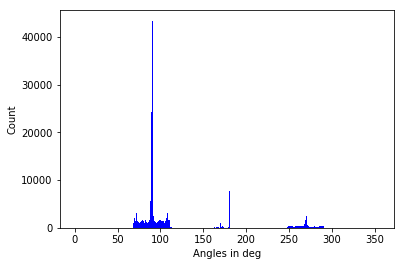

In [10]:
# angle distribution histogram
draw_hist(angles*180/math.pi,360,'blue','Angles in deg','Count')

In [11]:
# add number of edges column
n_edge = np.array([len(p) for p in poly[:,0]])
n_edge = n_edge.reshape((n_edge.shape[0],1))
poly = np.hstack((poly,n_edge))

(30206, 1)


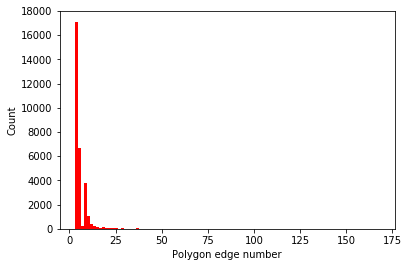

In [12]:
# histogram of number of edges
strat_edgeno = poly[:,2].copy()
strat_edgeno = strat_edgeno.reshape(-1, 1)
print(strat_edgeno.shape)
draw_hist(strat_edgeno,num_bins=100,color='red',xlabel='Polygon edge number',ylabel='Count')

In [13]:
poly = fix_single_class(poly, strat_edgeno)
#print(f'Out of f: {poly.shape}')

In [14]:
# random labels
prob = [0.3, 0.7]
y = np.random.choice([0,1], size=(poly.shape[0],1), p=prob)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(poly, y, test_size=0.33, stratify=poly[:,3])
print(f'X_Train: {X_train.shape}\nX_test: {X_test.shape}\nytrain: {y_train.shape}\nytest: {y_test.shape}')

X_Train: (20238, 4)
X_test: (9968, 4)
ytrain: (20238, 1)
ytest: (9968, 1)


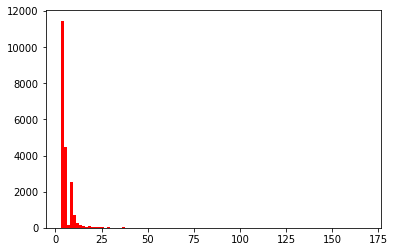

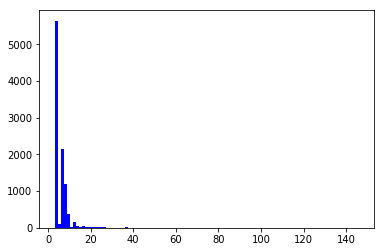

In [16]:
# test stratification
draw_hist(X_train[:,2].reshape(-1,1),100)
draw_hist(X_test[:,2].reshape(-1,1),100,color='blue')

In [17]:
X_train = np.delete(X_train, 3, 1)
X_test = np.delete(X_test, 3, 1)
#print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')


In [18]:
del polygons
del poly
del strat_edgeno
del y

In [30]:
# Sort descending by number of angles
argsorted = X_train[:,2].argsort()[::-1]
X_train_sorted = X_train[argsorted]
y_train_sorted = y_train[argsorted]
# for i in range(len(X_train)):
#     if i == 32:
#         break
#     print(f'{X_train[i,2]} - {X_train_sorted[i,2]}')

In [224]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.losses import sigmoid_cross_entropy


#TODO: Dataset u python array dimenzija (samples,n_angles,channels)

In [207]:
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, dX, dY, batch_size=32, in_channels=1,
                 out_channels=1):
        'Initialization'
        self.batch_size = batch_size
        self.dX = dX
        self.dY = dY
        self.in_channels = in_channels
        self.out_channels = out_channels
        # self.shuffle = shuffle
        # self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dX) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        # indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        # list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(index)

        return X, Y

    # def on_epoch_end(self):
    #     'Updates indexes after each epoch'
    #     self.indexes = np.arange(len(self.dX))
    #     if self.shuffle == True:
    #         np.random.shuffle(self.indexes)

    def __data_generation(self, index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        xb = self.dX[index*self.batch_size:(index+1)*self.batch_size]
        yb = self.dY[index*self.batch_size:(index+1)*self.batch_size]
        # longest = np.max(len(xb[]))
        # Initialization
        X = np.empty((self.batch_size, len(xb[0]), 2))
        # target 2 channels
        Y = np.empty((self.batch_size, 1))
        print(f'X shape:{X.shape} Y shape: {Y.shape})')
        X=np.array(xb)
        Y=np.array(yb)
        print(f'X shape:{X.shape} Y shape: {Y.shape})')
        print('--------------------------------------')
        # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             X[i], Y[i] = loadImgHsv('data/img_celeba/' + ID)
# #         print('X[i].shape:',X[0].shape)
# #         print('X.shape:',X.shape,'Y.shape',Y.shape)
#         X = np.expand_dims(X, axis=len(X.shape))
# #         print('X[i].shape:',X[0].shape)
# #         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [208]:
def createModel(batch_size=32):
    input = Input(shape = (None,2))
    x = Conv1D(filters=32,kernel_size=3,padding='valid')(input)
    x = GlobalAveragePooling1D()(x)
    x = Dense(8, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [209]:
x = np.random.randn(32,30,2).tolist()
x=x+np.random.randn(32,15,2).tolist()
x=x+np.random.randn(32,17,2).tolist()
x = np.array(x)
print(x.shape)
x=x.tolist()
prob = [0.3, 0.7]
y = np.random.choice([0,1], size=(96,1), p=prob).tolist()

X = np.random.randn(96,10,2)
Y = np.random.choice([0,1], size=(96,1), p=prob)

(96,)


In [219]:
train_generator = DataGenerator(x,Y,batch_size=32)

In [220]:
tf.keras.backend.clear_session()

In [221]:
model = createModel()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          224       
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [222]:
model.fit_generator(generator=train_generator,
                    epochs=3,
                    use_multiprocessing=False,
                    workers=0)

Epoch 1/3
X shape:(32, 30, 2) Y shape: (32, 1))
X shape:(32, 30, 2) Y shape: (32, 1))
--------------------------------------
1/3 [=========>....................] - ETA: 0s - loss: 0.6907 - acc: 0.5625

X shape:(32, 15, 2) Y shape: (32, 1))
X shape:(32, 15, 2) Y shape: (32, 1))
--------------------------------------
X shape:(32, 17, 2) Y shape: (32, 1))
X shape:(32, 17, 2) Y shape: (32, 1))
--------------------------------------


3/3 [==============================] - 0s 68ms/step - loss: 0.6913 - acc: 0.5417


Epoch 2/3
X shape:(32, 30, 2) Y shape: (32, 1))
X shape:(32, 30, 2) Y shape: (32, 1))
--------------------------------------
1/3 [=========>....................] - ETA: 0s - loss: 0.6825 - acc: 0.6875

X shape:(32, 15, 2) Y shape: (32, 1))
X shape:(32, 15, 2) Y shape: (32, 1))
--------------------------------------
X shape:(32, 17, 2) Y shape: (32, 1))
X shape:(32, 17, 2) Y shape: (32, 1))
--------------------------------------
3/3 [==============================] - 0s 6ms/step - loss: 0.6833 - acc: 0.6250


Epoch 3/3
X shape:(32, 30, 2) Y shape: (32, 1))
X shape:(32, 30, 2) Y shape: (32, 1))
--------------------------------------
1/3 [=========>....................] - ETA: 0s - loss: 0.6756 - acc: 0.7188

X shape:(32, 15, 2) Y shape: (32, 1))
X shape:(32, 15, 2) Y shape: (32, 1))
--------------------------------------
X shape:(32, 17, 2) Y shape: (32, 1))
X shape:(32, 17, 2) Y shape: (32, 1))
--------------------------------------
3/3 [==============================] - 0s 8ms/step - loss: 0.6762 - acc: 0.6875


In [214]:
np.array(x[:2]).shape

# for i in range(len(x)):
#     print(len(x[i]))
#     print(x[i])

# a = [[[1,2],[1,2],[1,2]],
#      [[1,2],[1,2],[1,2]],
#      [[1,2],[1,2]],
#      [[1,2],[1,2]]
#      ]
# a=np.array(a)
# a=a.tolist()
# A = np.array(a[:2])
# A.shape

# y=np.array(x[:2])
# print(y)
# print(y.shape)

(2, 30, 2)